In [2]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

In [18]:
INPUT_SIZE = 3 # thickness, height, angle
LATENT_DIM = 3
LEARNING_RATE = 0.001
BATCH_SIZE = 32 # 
NUM_EPOCHS = 50

TEST_SIZE = 0.2
RANDOM_STATE = 42
device = "cpu"

In [19]:
df = pd.read_csv(r'../MLP/processed_bending_stiffness.csv')

# Remove duplicates
initial_count = len(df)
df = df.drop_duplicates()
removed_count = initial_count - len(df)
if removed_count > 0:
    print(f"Removed {removed_count} duplicate row(s) from the dataset.")
print(f"Shape of dataset after removing duplicates: {df.shape}")
X = df[['Thickness', 'Height', 'Angle (deg)']]
y = df['Bending_Stiffness']

X_train, X_test, y_train, y_test = train_test_split(
    X.values, 
    y.values, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)
DATASET_SIZE = len(df) # Number of samples

Removed 685 duplicate row(s) from the dataset.
Shape of dataset after removing duplicates: (743, 4)


In [20]:
# Make all parameters have mean 0 and std 1 so parameters with a large scale don't skew 
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))  # Add .reshape(-1, 1)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))  # Add .reshape(-1, 1)

# Create DataLoaders
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)  # Now has shape [N, 1]
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

In [21]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=3, condition_dim=1, hidden_dim=16, latent_dim=LATENT_DIM, device=device):
        super(ConditionalVAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.ReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(0.2)
            )
        
        # latent space - mean and variance 
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, hidden_dim),
            nn.ReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
            )
     
    def encode(self, x, condition):
        x_with_condition = torch.cat([x, condition], dim=1)
        x = self.encoder(x_with_condition)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std).to(device)      
        z = mean + std * epsilon
        return z

    def decode(self, z, condition):
        # Concatenate latent with condition
        z = torch.cat([z, condition], dim=1)
        return self.decoder(z)

    def forward(self, x, condition):
        mean, logvar = self.encode(x, condition)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z, condition)
        return x_hat, mean, logvar

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [22]:
def loss_function(x, x_hat, mean, log_var):
    # VAE loss = Reconstruction loss + KL divergence
    reconstruction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kld

In [23]:
model = ConditionalVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        total_samples = 0
        for batch_idx, (x, condition) in enumerate(train_loader):
            x = x.to(device)
            condition = condition.to(device)
            current_batch_size = x.size(0)

            optimizer.zero_grad()

            #Forward pass
            x_hat, mean, log_var = model(x, condition)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            total_samples += current_batch_size
            
            # Backward pass
            loss.backward()
            optimizer.step()

        avg_loss = overall_loss / total_samples
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", (avg_loss))
    return overall_loss

train(model, optimizer, epochs=NUM_EPOCHS, device=device)

	Epoch 1 	Average Loss:  3.2455951292506775
	Epoch 2 	Average Loss:  3.0894101846097697
	Epoch 3 	Average Loss:  2.9517863045637855
	Epoch 4 	Average Loss:  2.7955960039337877
	Epoch 5 	Average Loss:  2.588841351595792
	Epoch 6 	Average Loss:  2.379872113365918
	Epoch 7 	Average Loss:  2.112199494332978
	Epoch 8 	Average Loss:  1.9161516247373638
	Epoch 9 	Average Loss:  1.8266185766920096
	Epoch 10 	Average Loss:  1.7725243680806273
	Epoch 11 	Average Loss:  1.732942060990767
	Epoch 12 	Average Loss:  1.7257592332884921
	Epoch 13 	Average Loss:  1.6940564274386525
	Epoch 14 	Average Loss:  1.6863117571230288
	Epoch 15 	Average Loss:  1.680653286301327
	Epoch 16 	Average Loss:  1.668518233379531
	Epoch 17 	Average Loss:  1.6663030373929726
	Epoch 18 	Average Loss:  1.657300682581635
	Epoch 19 	Average Loss:  1.6621388040407739
	Epoch 20 	Average Loss:  1.640985379716764
	Epoch 21 	Average Loss:  1.6168383941907272
	Epoch 22 	Average Loss:  1.6367003893611407
	Epoch 23 	Average Loss:  1

779.2249813079834

In [25]:
def generate(model, stiffness, x, y, samples, device='cpu'):
    model.eval()
    with torch.no_grad():
        normalized_stiffness = scaler_y.transform([[stiffness]])
        stiffness_tensor = torch.FloatTensor(normalized_stiffness).to(device) # Normalize 

        condition = stiffness_tensor.repeat(samples, 1) # Repeat for each sample

        z = torch.randn(samples, model.mean_layer.out_features).to(device)

        generated = model.decode(z, condition)

        generated_np = generated.cpu().numpy()
        designs = scaler_X.inverse_transform(generated_np)
    return designs

Generating 10 designs for target stiffness: 5000.0

TARGET STIFFNESS: 5000.0
#     Thickness       Height          Angle (deg)     Predicted       Error          
------------------------------------------------------------------------------------------
1     4.4665          80.8930         62.7244         5028.67         28.67          
2     4.9381          73.9330         59.0633         4851.55         148.45         
3     5.9984          65.2896         51.1040         4999.75         0.25           
4     4.4692          81.0900         62.9505         5046.84         46.84          
5     5.9623          69.0101         54.0727         5474.57         474.57         
6     4.9060          78.7999         62.0508         5361.56         361.56         
7     6.3637          69.0135         55.3890         5827.45         827.45         
8     5.3455          76.0466         60.8522         5478.86         478.86         
9     4.2339          78.4300         62.2911         4507

C:\Users\mason\AppData\Local\Temp\ipykernel_12156\1978405658.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


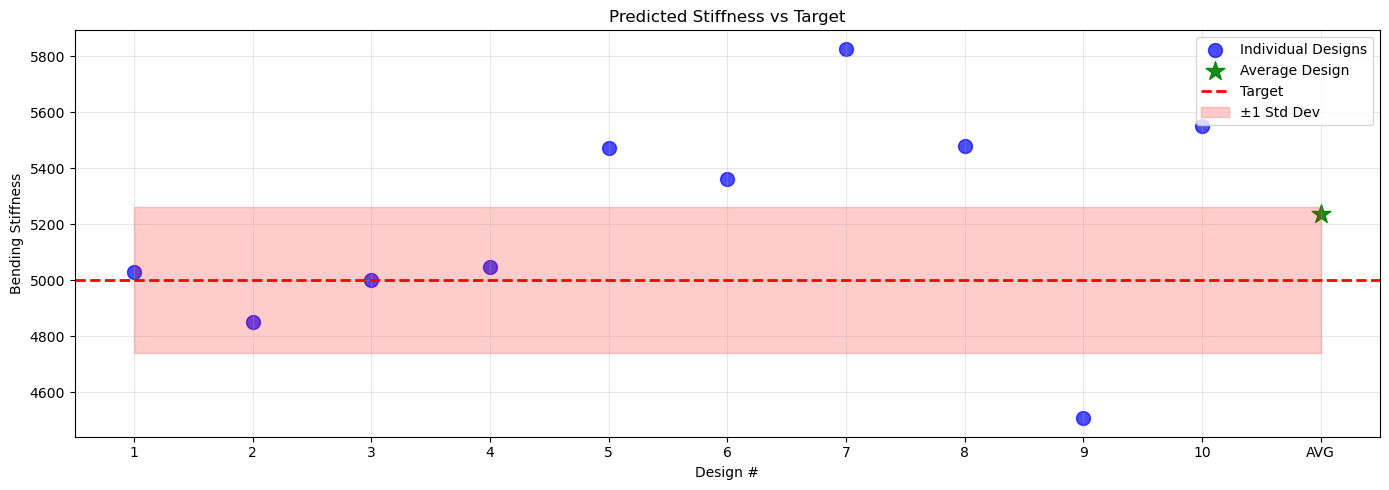


SUMMARY
Target Stiffness:                    5000.00
Mean Predicted (Individual Designs): 5212.98
Average Design Predicted:            5236.79

Mean Error (Individual Designs):     341.20
Average Design Error:                236.79

Improvement using Average:           104.41


In [28]:
# %%
# Load and prepare the forward model
forward_model = nn.Sequential(
    nn.Linear(3, 64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    
    nn.Linear(16, 1)
).to(device)

forward_model.load_state_dict(
    torch.load(
        r"C:\Users\mason\Work\CMEC_SandwichPanel\Models\MLP\Parameters_To_Stiffness\model_weight.pth",
        map_location=device
    )
)
forward_model.eval()

# %%
def verify_designs(designs, forward_model, scaler_X, scaler_y, target_stiffness, device='cpu'):
    """Verify individual designs using the forward model"""
    forward_model.eval()
    
    with torch.no_grad():
        # Convert designs to tensor (designs are already denormalized from VAE)
        designs_tensor = torch.FloatTensor(designs).to(device)
        
        # Predict stiffness using forward model (expects denormalized input)
        predicted_stiffness = forward_model(designs_tensor)
        
        # Convert to numpy
        predicted_stiffness = predicted_stiffness.cpu().numpy()
        
    return predicted_stiffness.flatten()

def verify_average_design(designs, forward_model, device='cpu'):
    """Calculate average design and predict its stiffness"""
    forward_model.eval()
    
    # Calculate average design parameters
    avg_thickness = np.mean(designs[:, 0])
    avg_height = np.mean(designs[:, 1])
    avg_angle = np.mean(designs[:, 2])
    
    avg_design = np.array([[avg_thickness, avg_height, avg_angle]])
    
    with torch.no_grad():
        # Convert to tensor
        avg_design_tensor = torch.FloatTensor(avg_design).to(device)
        
        # Predict stiffness for average design
        avg_predicted_stiffness = forward_model(avg_design_tensor)
        avg_predicted_stiffness = avg_predicted_stiffness.cpu().numpy().flatten()[0]
    
    return avg_design, avg_predicted_stiffness

# Generate designs for a target stiffness
test_stiffness = 5000.0
n_samples = 10

print(f"Generating {n_samples} designs for target stiffness: {test_stiffness}")
designs = generate(model, test_stiffness, scaler_X, scaler_y, samples=n_samples, device=device)

# Verify the designs using forward model
predicted_stiffness = verify_designs(designs, forward_model, scaler_X, scaler_y, 
                                     test_stiffness, device=device)

# Verify the average design
avg_design, avg_predicted_stiffness = verify_average_design(designs, forward_model, device=device)

# Display results
print("\n" + "="*90)
print(f"TARGET STIFFNESS: {test_stiffness}")
print("="*90)
print(f"{'#':<5} {'Thickness':<15} {'Height':<15} {'Angle (deg)':<15} {'Predicted':<15} {'Error':<15}")
print("-"*90)

errors = []
for i, (design, pred_stiff) in enumerate(zip(designs, predicted_stiffness), 1):
    error = abs(pred_stiff - test_stiffness)
    errors.append(error)
    print(f"{i:<5} {design[0]:<15.4f} {design[1]:<15.4f} {design[2]:<15.4f} "
          f"{pred_stiff:<15.2f} {error:<15.2f}")

print("-"*90)
print(f"Mean Absolute Error: {np.mean(errors):.2f}")
print(f"Std Dev of Error: {np.std(errors):.2f}")
print(f"Min Error: {np.min(errors):.2f}")
print(f"Max Error: {np.max(errors):.2f}")

# Display average design
print("\n" + "="*90)
print("AVERAGE DESIGN")
print("="*90)
avg_error = abs(avg_predicted_stiffness - test_stiffness)
print(f"{'Type':<5} {'Thickness':<15} {'Height':<15} {'Angle (deg)':<15} {'Predicted':<15} {'Error':<15}")
print("-"*90)
print(f"{'AVG':<5} {avg_design[0][0]:<15.4f} {avg_design[0][1]:<15.4f} {avg_design[0][2]:<15.4f} "
      f"{avg_predicted_stiffness:<15.2f} {avg_error:<15.2f}")
print("-"*90)

# Compare with actual closest designs from dataset
print("\n" + "="*90)
print("ACTUAL CLOSEST DESIGNS FROM DATASET")
print("="*90)

df['diff'] = (df['Bending_Stiffness'] - test_stiffness).abs()
closest_rows = df.nsmallest(5, 'diff')

print(f"{'#':<5} {'Thickness':<15} {'Height':<15} {'Angle (deg)':<15} {'Stiffness':<15} {'Error':<15}")
print("-"*90)
for i, (idx, row) in enumerate(closest_rows.iterrows(), 1):
    print(f"{i:<5} {row['Thickness']:<15.4f} {row['Height']:<15.4f} "
          f"{row['Angle (deg)']:<15.4f} {row['Bending_Stiffness']:<15.2f} {row['diff']:<15.2f}")

fig, axes = plt.subplots(figsize=(14, 5))
# Predicted vs Target stiffness (including average)
axes.scatter(range(1, n_samples+1), predicted_stiffness, 
            label='Individual Designs', alpha=0.7, s=100, color='blue')
axes.scatter([n_samples+1], [avg_predicted_stiffness], 
            label='Average Design', alpha=0.9, s=200, color='green', marker='*')
axes.axhline(y=test_stiffness, color='r', linestyle='--', linewidth=2, label='Target')
axes.fill_between(range(1, n_samples+2), 
                  test_stiffness - np.std(errors), 
                  test_stiffness + np.std(errors), 
                  alpha=0.2, color='red', label='±1 Std Dev')
axes.set_xlabel('Design #')
axes.set_ylabel('Bending Stiffness')
axes.set_title('Predicted Stiffness vs Target')
axes.legend()
axes.grid(True, alpha=0.3)
axes.set_xticks(range(1, n_samples+2))
axes.set_xticklabels([str(i) for i in range(1, n_samples+1)] + ['AVG'])

plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("SUMMARY")
print("="*90)
print(f"Target Stiffness:                    {test_stiffness:.2f}")
print(f"Mean Predicted (Individual Designs): {np.mean(predicted_stiffness):.2f}")
print(f"Average Design Predicted:            {avg_predicted_stiffness:.2f}")
print(f"")
print(f"Mean Error (Individual Designs):     {np.mean(errors):.2f}")
print(f"Average Design Error:                {avg_error:.2f}")
print(f"")
print(f"Improvement using Average:           {np.mean(errors) - avg_error:.2f}")
